# Multi-Gradients Anti-Deep Leakage model

# Introduction

**School: National Chiayi University**

**Professor: Chih-Hung Wang (王智弘)**

**Students: Information security members and Wei-Chun Hsiao (蕭維均)**

This model extend from "Deep Leakage from Gradients"

https://dlg.mit.edu/

We provide an inovation method for preventing deep leakage.


# Method

This is an adapter style model for preventing deep leakage attack, that can append after any dense layer.

This adapter consists of multi path dense layers and average pooling.

Make attackers hard to simply compute back training datas.

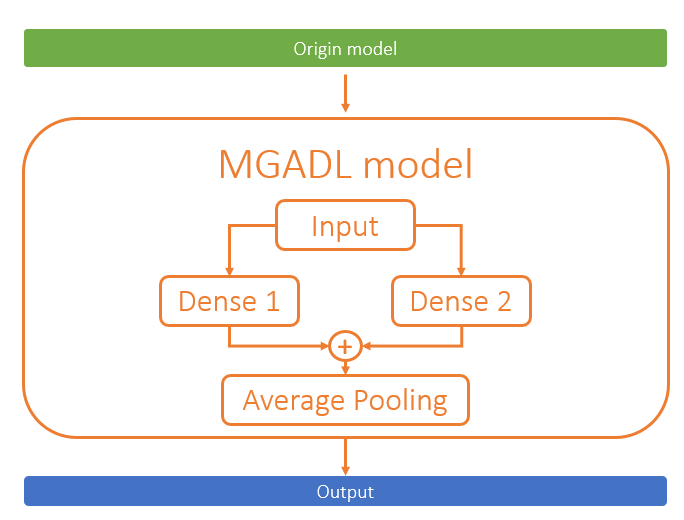

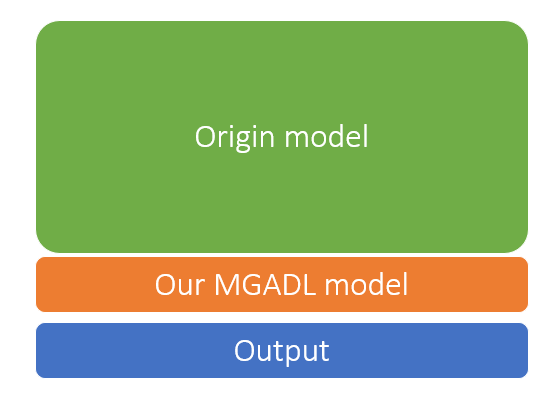

# Import Python modules

In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.utils.data as data_utils
from torch.nn.functional import normalize

torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

2.2.0.dev20230916+cu121 0.17.0.dev20230917+cu121


# Set Training Epoch and Deep leakage epoch

In [2]:
training_epoch_num = 5
deep_leakage_epoch_num = 200

# Prepare training data and set batch size

In [3]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

dst = datasets.CIFAR100('./dataset', download=True, train=True, transform=tp)
dst_test = datasets.CIFAR100('./dataset', download=True, train=False, transform=tp)

# Detect CPU or GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

Files already downloaded and verified
Files already downloaded and verified
Running on cuda


In [4]:
batch_size = 32

train_loader = data_utils.DataLoader(dataset = dst, batch_size = batch_size, shuffle = True)
test_loader = data_utils.DataLoader(dataset = dst_test, batch_size = batch_size, shuffle = True)

print(train_loader)
print(test_loader)
print(len(dst), len(dst)/batch_size)
print(len(dst_test),len(dst_test)/batch_size)

50000 1562.5
10000 312.5


# Loss function

In [5]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

criterion = cross_entropy_for_onehot

# Define models and init weights

In [6]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

In [7]:
class MGADLNet(nn.Module):
    def __init__(self):
        super(MGADLNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(768, 800)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(768, 800)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(100, 100)
        )

        self.pooling = nn.AvgPool1d(kernel_size = 8)
        
        # layer_norm = nn.LayerNorm(4, eps=1e-6)

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out_b1 = self.fc1(out)
        out_b2 = self.fc2(out)
        out = out_b1 + out_b2
        out = self.pooling(out)
        out = normalize(out , p=4.0, dim = 0)
        out = self.fc3(out)
        return out

# Activating our model

In [8]:
net = MGADLNet().to(device)

net.apply(weights_init)

MGADLNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc1): Sequential(
    (0): Linear(in_features=768, out_features=800, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=800, bias=True)
  )
  (fc3): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
  )
  (pooling): AvgPool1d(kernel_size=(8,), stride=(8,), padding=(0,))
)

# Traning our model

In [9]:
# Training Original model
mode = net.train()
Learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr = Learning_rate, momentum=0.9)
loss_history = []
accuracy_history = []
loss_fn = nn.CrossEntropyLoss()

for i in range(0, training_epoch_num):
    for j, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()

        y_pred = net(x_train)

        loss = loss_fn(y_pred, y_train)

        loss.backward()

        optimizer.step()

        #Loss
        loss_history.append(loss.item())

        #Accuarcy
        number_batch = y_train.size()[0]
        _, predicted = torch.max(y_pred.data, dim = 1)
        correct_batch = (predicted == y_train).sum().item()
        accuracy_batch = 100 * correct_batch/number_batch
        accuracy_history.append(accuracy_batch)

        if(j % 500 == 0):
            print('epoch {} batch {} In {} loss = {:.4f} accuracy = {:.4f}%'.format(i, j , len(dst)/batch_size, loss.item(), accuracy_batch))

epoch 0 batch 0 In 1562.5 loss = 5.2284 accuracy = 0.0000%
epoch 0 batch 500 In 1562.5 loss = 4.5959 accuracy = 0.0000%
epoch 0 batch 1000 In 1562.5 loss = 4.4734 accuracy = 0.0000%
epoch 0 batch 1500 In 1562.5 loss = 4.2440 accuracy = 0.0000%
epoch 1 batch 0 In 1562.5 loss = 4.0950 accuracy = 9.3750%
epoch 1 batch 500 In 1562.5 loss = 3.8938 accuracy = 9.3750%
epoch 1 batch 1000 In 1562.5 loss = 3.8863 accuracy = 18.7500%
epoch 1 batch 1500 In 1562.5 loss = 3.7603 accuracy = 15.6250%
epoch 2 batch 0 In 1562.5 loss = 3.8364 accuracy = 6.2500%
epoch 2 batch 500 In 1562.5 loss = 3.8736 accuracy = 6.2500%
epoch 2 batch 1000 In 1562.5 loss = 3.8194 accuracy = 6.2500%
epoch 2 batch 1500 In 1562.5 loss = 3.9712 accuracy = 9.3750%
epoch 3 batch 0 In 1562.5 loss = 4.2110 accuracy = 9.3750%
epoch 3 batch 500 In 1562.5 loss = 3.0985 accuracy = 31.2500%
epoch 3 batch 1000 In 1562.5 loss = 3.5424 accuracy = 21.8750%
epoch 3 batch 1500 In 1562.5 loss = 3.7602 accuracy = 15.6250%
epoch 4 batch 0 In 

# Test our model

In [10]:
def test(): 
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = loss_fn(output, target)
        acc+=torch.sum(torch.argmax(output,dim=1)==target).item()
        sum+=len(target)
        loss_sum+=loss.item()
    print('test  acc: %.2f%%, loss: %.4f'%(100*acc/sum, loss_sum/(batch+1)))

test()

test  acc: 16.90%, loss: 3.5372


# Extract gradients from our model

GT label is 84. 
Onehot label is 84.


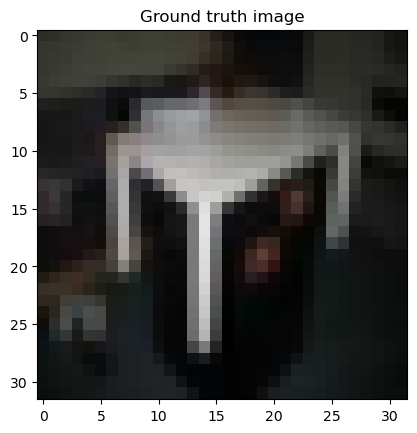

In [11]:
######### honest partipant #########
img_index = 25
gt_data = dst[img_index][0].to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# Generating dummy data

Dummy label is 30.


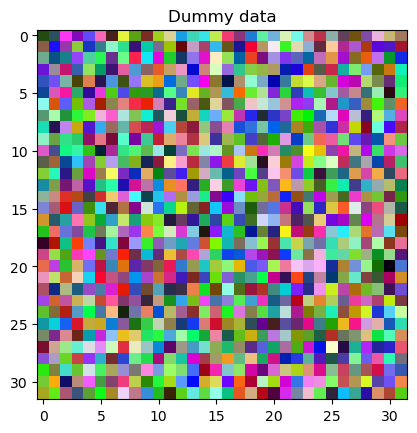

In [12]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# Deep Leakage program

In [13]:
#Training Attack model
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(deep_leakage_epoch_num):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 122.3071
10 122.3071
20 122.3070
30 122.3069
40 122.3067
50 122.3065
60 122.3062
70 122.3050
80 122.2813
90 170.6452
100 170.6452
110 183.1023
120 183.1023
130 183.1023
140 183.1023
150 183.1023
160 183.1023
170 183.1023
180 183.1023
190 183.1023


# Showing figures

Dummy label is 84.


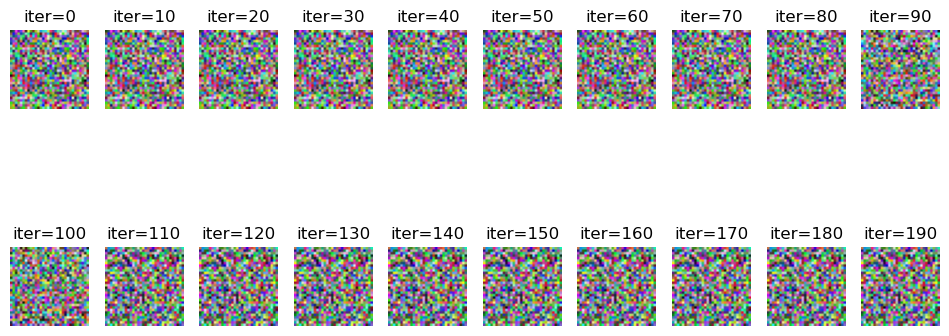

In [14]:
plt.figure(figsize=(12, 8))
for i in range(deep_leakage_epoch_num//10):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())